## Imports

In [1]:
import os

import pandas as pd
import numpy as np

import librosa
import librosa.display

from IPython.display import Audio

from PIL import Image, ImageOps

import matplotlib.cm as cm

## File Paths

In [2]:
audio_input_folder = "./data/train_audio"
image_output_folder = "./data/working/train_images"
meta_data = pd.read_csv("./data/eBird_Taxonomy_v2021.csv")

In [3]:
birds_of_interest = [
    "Eurasian Coot", #
    "Blyth's Reed Warbler", #
    "Gray Heron", #
    "Greenish Warbler", #
    "Black-crowned Night-Heron", 
    "Rose-ringed Parakeet", #
    "Greater Racket-tailed Drongo", #
    "White-breasted Waterhen", #
    "Gray-headed Canary-Flycatcher", #
    "Great Egret", #
    "Little Egret", #
    "Red-whiskered Bulbul"#
]

print(len(birds_of_interest))

12


In [4]:
metadata_of_interest = meta_data[meta_data['PRIMARY_COM_NAME'].isin(birds_of_interest)]
print(metadata_of_interest.shape)
metadata_of_interest

(12, 9)


,TAXON_ORDER,CATEGORY,SPECIES_CODE,PRIMARY_COM_NAME,SCI_NAME,ORDER1,FAMILY,SPECIES_GROUP,REPORT_AS
2753,5346,species,eurcoo,Eurasian Coot,Fulica atra,Gruiformes,"Rallidae (Rails, Gallinules, and Coots)",NaN,NaN
2797,5407,species,whbwat1,White-breasted Waterhen,Amaurornis phoenicurus,Gruiformes,"Rallidae (Rails, Gallinules, and Coots)",NaN,NaN
4013,7176,species,graher1,Gray Heron,Ardea cinerea,Pelecaniformes,"Ardeidae (Herons, Egrets, and Bitterns)",NaN,NaN
4030,7200,species,greegr,Great Egret,Ardea alba,Pelecaniformes,"Ardeidae (Herons, Egrets, and Bitterns)",NaN,NaN
4045,7217,species,litegr,Little Egret,Egretta garzetta,Pelecaniformes,"Ardeidae (Herons, Egrets, and Bitterns)",NaN,NaN
4095,7305,species,bcnher,Black-crowned Night-Heron,Nycticorax nycticorax,Pelecaniformes,"Ardeidae (Herons, Egrets, and Bitterns)",NaN,NaN
6335,11807,species,rorpar,Rose-ringed Parakeet,Psittacula krameri,Psittaciformes,Psittaculidae (Old World Parrots),NaN,NaN
10079,19754,species,grtdro1,Greater Racket-tailed Drongo,Dicrurus paradiseus,Passeriformes,Dicruridae (Drongos),NaN,NaN
10670,21121,species,gyhcaf1,Gray-headed Canary-Flycatcher,Culicicapa ceylonensis,Passeriformes,Stenostiridae (Fairy Flycatchers),NaN,NaN
11263,22828,species,blrwar1,Blyth's Reed Warbler,Acrocephalus dumetorum,Passeriformes,Acrocephalidae (Reed Warblers and Allies),NaN,NaN


## Settings

In [5]:
#generates spectrograms are generated on audio clips this long
#audio clips shorter than this are ignored
audio_duration = 5.0

#generates up to this many clips per file (multiples of audio_duration)
#remainders of audio clip length / audio_duration are ignored
max_clips_per_audio_file = 1000

#image size (image_size x image_size)
image_size = 224

#processes up to this many audio files per species
max_audio_input_per_species = 1000

#setting this above 0 will cause processing to start at a folder after the first
#useful for restarting / continuing in case of running out of time / crash (folders are processed alphabetically)
start_at_folder_offset = 0

In [6]:
def bird_species_from_folder(path):
    if path.endswith('/'):
        path = path[:-1]

    last_folder = os.path.basename(path)
    primary_com_name = metadata_of_interest.loc[metadata_of_interest['SPECIES_CODE'] == last_folder, 'PRIMARY_COM_NAME']
    primary_com_name_str = primary_com_name.iloc[0] if not primary_com_name.empty else ''    
    return f"{primary_com_name_str} ({last_folder})"

In [7]:
def spectrograms_for_audio(dirname, filename, preview=False):
    # Calculate total duration of the audio file
    audio_path = os.path.join(dirname, filename)
    audio_data, sr = librosa.load(audio_path, sr=None)
    total_duration = librosa.get_duration(path=audio_path)
    
    # Determine how many full segments of audio_duration fit in the audio file
    num_segments = int(total_duration // audio_duration)
    if num_segments == 0: return 0
    if num_segments > max_clips_per_audio_file: num_segments = max_clips_per_audio_file
        
    for segment in range(num_segments):

        offset_samples = int(segment * audio_duration * sr)
        end_samples = int(offset_samples + audio_duration * sr)
        
        segment_data = audio_data[offset_samples:end_samples]
        
        S = librosa.feature.melspectrogram(y=segment_data, sr=sr, n_mels=128)
        S_db = librosa.amplitude_to_db(S, ref=np.max)
                
        #convert spectrogram data into directly into image (much faster than matplotlib)
        normalized_array = (S_db - np.min(S_db)) / (np.max(S_db) - np.min(S_db))
        
        #set color mapping 
        spectrogram_image = cm.magma(normalized_array)[:, :, :3]
        spectrogram_image = (spectrogram_image * 255).astype(np.uint8)
        spectrogram_image = Image.fromarray(spectrogram_image)
        
        #resize and flip (so consistent with original dataset)
        spectrogram_image = spectrogram_image.resize((image_size, image_size), Image.LANCZOS)
        spectrogram_image = ImageOps.flip(spectrogram_image)
        
        if preview == True:
            display(Audio(data=segment_data, rate=sr))
            return spectrogram_image
        
        output_folder = os.path.join(image_output_folder, os.path.basename(os.path.normpath(dirname)))
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)

        # Naming files with an offset to indicate seconds offset
        base_filename = filename.replace('.ogg', '')
        output_filename = os.path.join(output_folder, f"{base_filename}_{int((segment + 1) * audio_duration):02d}.png")
        
        spectrogram_image.save(output_filename)

    return num_segments

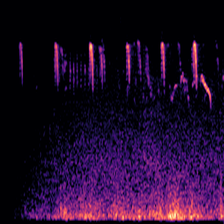

In [9]:
spectrograms_for_audio("./data/train_audio/zitcis1/", "XC655341.ogg", preview=True)

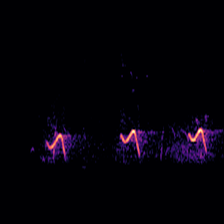

In [10]:
spectrograms_for_audio("./data/train_audio/asikoe2/", "XC138196.ogg", preview=True)

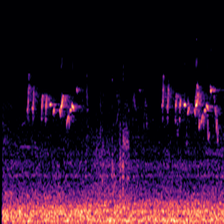

In [11]:
spectrograms_for_audio("./data/train_audio/bkcbul1/", "XC129030.ogg", preview=True)